In [1]:
import tensorflow as tf

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()  #데이터 로드, test이미지 필요 없어서 생략
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #샘플개수, (28,28,1)
train_images = (train_images - 127.5) / 127.5 #노멀라이즈

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)  #셔플하고 배치사이즈로 자름

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # output: 7*7*256이 flatten. input은 100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256))) 

    # 이제 이미지를 키워줘야함. 28*28*256으로
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #upsampling하면 14가 된다.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #upsampling하면 28가 된다. with 64짜리 채널사이즈
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #원래 이미지는 채널 사이즈가 1임. = gray scale이라서
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  #채널사이즈 줄임

    return model

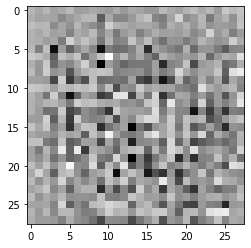

In [5]:
#generator 잘 되는지 추출해봄
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten()) # spacial한것을 1D로 만듬
    model.add(layers.Dense(1))

    return model

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00026698]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #output이 0 아니면 1이다

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) #1하고 비교할것
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #0하고 비교할 것
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #fake가 1이 되도록(real이 되도록) 만들어야 함

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
#학습 함수
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

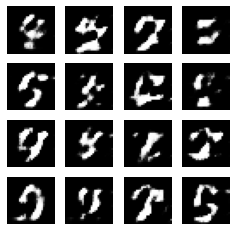

In [16]:
train(train_dataset, EPOCHS)